In [24]:
setwd("/Users/micaelawiseman/PhD/Thesis/Winterlight")
source("/Users/micaelawiseman/PhD/Thesis/Winterlight/Code/WL_helperfuncs.r", encoding = "UTF-8")

Load and clean data

In [29]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv")
WL_2 <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMSremote_2023_11_03.csv")

# Apply filters
WL <- WL[grep("^(TMS|MDD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"

# Combine datasets
WL_combined <- rbind(WL, WL_2)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD)", WL_combined$participant_external_id), "MDD", NA)
  )
)

# Exclude specific participants
WL_combined <- WL_combined[WL_combined$participant_external_id != "CTC036", ]

# Define remote participants and assign testing location
remote_participants <- c("CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030", 
                         "CTC034", "CTC036", "CTC045", "TMS038", "TMS040", "TMS041", "TMS042")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")

# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

# Read and process demographic data
demoMDD <- demo_read_and_process(1)
demoCTRL <- demo_read_and_process(2)

# Generate new column names
column_mapping <- setNames(
    # Old names
  c(paste0(rep(c("bl_", "2wk_", "4wk_"), each = 1), "qids_tot"),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 16), "qids_sr_", 1:16),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_", 1:8),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_tot")),
  # New names
  c(paste0("qids_total_", c("pre", "wk2", "wk4")),
    paste0("qids_", 1:16, "_", rep(c("pre", "wk2", "wk4"), each = 16)),
    paste0("gad7_", 1:8, "_", rep(c("pre", "wk2", "wk4"), each = 8)),
    paste0("gad7_total_", rep(c("pre", "wk2", "wk4"), each = 8)))
)

# Remove leading and trailing whitespaces from column names in demoCTRL
demoCTRL <- demoCTRL %>%
  rename_all(~trimws(.))

# Rename columns in demoCTRL
demoCTRL <- demoCTRL %>% rename(!!!column_mapping)

# Combine demographic datasets
demoMDD$dob_yr <- as.numeric(demoMDD$dob_yr)
demoCTRL$dob_yr <- as.numeric(demoCTRL$dob_yr)
demoALL <- bind_rows(demoMDD, demoCTRL)

# Merge relevant columns from demoALL into WL

WL_demo <- WL_combined %>% left_join(demoALL %>% select(participant_external_id, sex,
                                          age_screening,
                                          years_education,
                                          age_learned_english,
                                          first_language_english,
                                          starts_with("qids"),
                                          starts_with("gad7")))

# Read in psychiatry data
psych <- read_csv("~/PhD/Thesis/Data/Final_Consolidated_Psychiatry_Data.csv")

# Filter to match participant IDs in WL_demo
psych_filtered <- psych %>%
  filter(participant_external_id %in% WL_demo$participant_external_id)

# Merge the datasets based on "participant_external_id" and retain all columns
# Use full_join to include all participants from both datasets
WL_demo_psych <- full_join(psych_filtered %>% select(participant_external_id,
                                              starts_with("hamd17"),
                                              starts_with("qids"),
                                              starts_with("gad7")),
                           WL_demo,
                           by = "participant_external_id",
                           suffix = c("", ".psych"))

# Identify common columns (excluding "participant_external_id")
common_columns <- setdiff(intersect(names(WL_demo), names(psych_filtered)), "participant_external_id")

# Update NA values in WL_demo columns with values from psych where applicable
WL_demo_psych <- WL_demo_psych %>%
  mutate(across(all_of(common_columns), 
  ~ifelse(is.na(.), get(paste0(cur_column(), ".psych")), .)))

# Optionally, remove the extra columns if they are no longer needed
WL_demo_psych <- select(WL_demo_psych, -ends_with(".psych"))

# Check the structure of the final dataframe
str(WL_demo_psych)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Joining with `by = join_by(participant_external_id)`
Rows: 48 Columns: 976
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (71): participant_external_id, demographic_data_timestamp, demog_househ...
dbl (785): demog_gender, demog_sex, demog_age, demog_married, demog_children...
lgl (120): demog_gender_other, demog_sex_other, pretreatment_clinician_admin...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [1,090 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:1090] "TMS001" "TMS001" "TMS001" "TMS001" ...
 $ hamd17_1_pre                                               : num [1:1090] 4 4 4 4 4 4 4 4 4 4 ...
 $ hamd17_2_pre                                               : num [1:1090] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_3_pre                                               : num [1:1090] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_4_pre                                               : num [1:1090] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_5_pre                                               : num [1:1090] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_6_pre                                               : num [1:1090] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_7_pre                                               : num [1:1090] 3 3 3 3 3 3 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:1090] 1 1 1 1 1 1 1 1 1 1 ...
 $ hamd17_9_pre         

Select psych columns of interest

In [30]:
# Selecting psych score columns
psych_columns <- c(grep("hamd17_(total|depression|insomnia|somatic|anxiety|suicide)_pre", names(WL_demo_psych), value = TRUE))

psych_columns_df <- WL_demo_psych %>% select(participant_external_id, all_of(psych_columns))

Subset by task (journalling) and visit (baseline)

In [31]:
# Subset to look at journaling and baseline scores
WL_full_jou <-subset_by_task(WL_demo_psych, "journaling")
WL_full_jou_bl<-subset_by_visit(WL_full_jou, "V1")

str(WL_full_jou_bl)

tibble [154 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:154] "TMS001" "TMS001" "TMS002" "TMS002" ...
 $ hamd17_1_pre                                               : num [1:154] 4 4 3 3 3 3 3 3 4 4 ...
 $ hamd17_2_pre                                               : num [1:154] 2 2 0 0 1 1 3 3 2 2 ...
 $ hamd17_3_pre                                               : num [1:154] 0 0 4 4 2 2 2 2 2 2 ...
 $ hamd17_4_pre                                               : num [1:154] 2 2 1 1 1 1 0 0 2 2 ...
 $ hamd17_5_pre                                               : num [1:154] 0 0 0 0 1 1 2 2 0 0 ...
 $ hamd17_6_pre                                               : num [1:154] 0 0 2 2 2 2 2 2 0 0 ...
 $ hamd17_7_pre                                               : num [1:154] 3 3 3 3 4 4 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:154] 1 1 0 0 1 1 0 0 1 1 ...
 $ hamd17_9_pre                    

Narrow down and specify target clinical, speech, and demographic variables 


In [32]:
# Categorizing variables into Clinical, Demographic, and Speech variables
clinical_variables <- c("hamd17_total_pre","hamd17_depression_pre", "hamd17_anxiety_pre",
                    "hamd17_somatic_pre", "hamd17_suicide_pre", "hamd17_insomnia_pre")
demographic_variables <- c('sex', 'age_screening', 'participant_group', 'age_learned_english', 'testing_location','years_education',"first_language_english")
speech_variables <- c('fundamental_frequency_mean','fundamental_frequency_range',
                    'fundamental_frequency_variance', 'intensity_mean_db','intensity_range',
                    'long_pause_count_normalized','long_pause_duration', 'medium_pause_count_normalized','medium_pause_duration',
                    'speech_rate', 'sentiment_dominance', 'sentiment_valence',
                    'sentiment_arousal')

# Creating subsets of data based on these categories
clinical_data <- WL_full_jou_bl[, c("participant_external_id", clinical_variables)]
demographic_data <- WL_full_jou_bl[, c("participant_external_id", demographic_variables)]
speech_data <- WL_full_jou_bl[, c("participant_external_id", speech_variables)]

# Checking the number of variables in each category
len_clinical <- length(clinical_variables)
len_demographic <- length(demographic_variables)
len_speech <- length(speech_variables)

# Displaying the number of variables in each category and first 5 variables from each category for verification
list(
  LenClinical = len_clinical,
  LenDemographic = len_demographic,
  LenSpeech = len_speech,
  ClinicalVariablesFirst5 = head(clinical_variables, 5),
  DemographicVariables = demographic_variables,
  SpeechVariablesFirst5 = head(speech_variables, 5)
)

$LenClinical
[1] 6

$LenDemographic
[1] 7

$LenSpeech
[1] 13

$ClinicalVariablesFirst5
[1] "hamd17_total_pre"      "hamd17_depression_pre" "hamd17_anxiety_pre"   
[4] "hamd17_somatic_pre"    "hamd17_suicide_pre"   

$DemographicVariables
[1] "sex"                    "age_screening"          "participant_group"     
[4] "age_learned_english"    "testing_location"       "years_education"       
[7] "first_language_english"

$SpeechVariablesFirst5
[1] "fundamental_frequency_mean"     "fundamental_frequency_range"   
[3] "fundamental_frequency_variance" "intensity_mean_db"             
[5] "intensity_range"

Check missing data

In [28]:
# For speech data
speech_missing <- analyze_missing_data(speech_data, "participant_external_id")
write.csv(speech_missing, "~/PhD/Thesis/Data/speech_missing.csv")


# For clinical data
clinical_missing <- analyze_missing_data(clinical_data, "participant_external_id")
write.csv(clinical_missing, "~/PhD/Thesis/Data/clinical_missing.csv")


# For demographic data
demographic_missing <- analyze_missing_data(demographic_data, "participant_external_id")
write.csv(demographic_missing, "~/PhD/Thesis/Data/demographic_missing.csv")


Linear models in MDD patients 

In [35]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("lmtest")

library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")


results <- list()
plots <- list()

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
  dir.create(plots_directory)
}

for (s in speech_variables) {
    for (c in clinical_variables) {
        # Filter out observations where sex is NA
        filtered_data <- WL_jou_bl_MDD_feeling %>%
                         filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(!!as.symbol(c)))

        # Linear regression with interaction term
        formula <- as.formula(paste(c, "~", s, "* sex + age_screening + age_learned_english"))
        model <- lm(formula, data = filtered_data)
        
        # Summary of the model
        model_summary <- summary(model)
        
        # Store the summary result
        results[[paste(s, c, "interaction", sep = "_")]] <- model_summary

        # Create a plot
        plot_name <- paste(s, c, "interaction_plot", sep = "_")
        plot <- ggplot(filtered_data, aes_string(x = s, y = c, color = "sex")) +
                geom_point(alpha = 0.6) +
                geom_smooth(method = "lm", se = FALSE, aes_string(group = "sex", color = "sex")) +
                labs(title = paste(s, "X", c),
                     x = s, y = c) +
                theme_minimal() +
                theme(plot.title = element_text(size =17)) # smaller title

        # Save the plot
        file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
        ggsave(file_name, plot, width = 6, height = 4, bg = "white")
    }
}

print(plots)
print(results)



The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//RtmpGudgpp/downloaded_packages

The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//RtmpGudgpp/downloaded_packages

The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//RtmpGudgpp/downloaded_packages


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$fundamental_frequency_mean_hamd17_total_pre_interaction

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.6849 -3.4398 -0.2869  1.9595  9.5254 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)  
(Intercept)                     13.00107    5.73387   2.267   0.0303 *
fundamental_frequency_mean       0.04747    0.03019   1.572   0.1257  
sexM                            10.11703   11.92776   0.848   0.4026  
age_screening                    0.01311    0.05611   0.234   0.8168  
age_learned_english             -0.04740    0.13094  -0.362   0.7197  
fundamental_frequency_mean:sexM -0.06701    0.10085  -0.664   0.5112  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.242 on 32 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.07731,	Adjusted R-squared:  -0.06686 
F-statistic: 0.5362 on 5 and 32 DF,  p-value: 0.7

Post hoc tests for linear models

In [37]:
# Initialize lists to store model summaries
results_F <- list()
results_M <- list()

for (s in speech_variables) {
    for (c in clinical_variables) {
        # Construct the formula
        formula <- as.formula(paste(c, "~", s, "+ age_screening + age_learned_english"))

        # Fit the model for females
        model_F <- lm(formula, data = filter(WL_jou_bl_MDD_feeling, sex == "F"))
        summary_F <- summary(model_F)
        if (any(summary_F$coefficients[2, "Pr(>|t|)"] < 0.05, na.rm = TRUE)) {
            # If any coefficient is significant, store the summary
            results_F[[paste(s, c, "F", sep = "_")]] <- summary_F
        }

        # Fit the model for males
        model_M <- lm(formula, data = filter(WL_jou_bl_MDD_feeling, sex == "M"))
        summary_M <- summary(model_M)
        if (any(summary_M$coefficients[2, "Pr(>|t|)"] < 0.05, na.rm = TRUE)) {
            # If any coefficient is significant, store the summary
            results_M[[paste(s, c, "M", sep = "_")]] <- summary_M
        }
    }
}

# Print only significant results
print("Significant Results for Females:")
print(results_F)
print("Significant Results for Males:")
print(results_M)



[1] "Significant Results for Females:"
$fundamental_frequency_mean_hamd17_anxiety_pre_F

Call:
lm(formula = formula, data = filter(WL_jou_bl_MDD_feeling, sex == 
    "F"))

Residuals:
   Min     1Q Median     3Q    Max 
-4.451 -1.077  0.152  1.137  4.858 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)  
(Intercept)                -0.19002    3.90225  -0.049   0.9617  
fundamental_frequency_mean  0.03814    0.01766   2.160   0.0453 *
age_screening              -0.02250    0.04960  -0.454   0.6559  
age_learned_english        -0.04470    0.14477  -0.309   0.7612  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.421 on 17 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.2596,	Adjusted R-squared:  0.129 
F-statistic: 1.987 on 3 and 17 DF,  p-value: 0.1542


$intensity_mean_db_hamd17_depression_pre_F

Call:
lm(formula = formula, data = filter(WL_jou_bl_MDD_feeling, sex == 
  

ANCOVAS by group controlling for sex 

$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                    Sum Sq Df  F value    Pr(>F)    
(Intercept)         230945  1 311.4514 < 2.2e-16 ***
participant_group     4318  1   5.8229   0.01865 *  
sex                  33161  1  44.7213 6.165e-09 ***
age_learned_english     33  1   0.0441   0.83424    
age_screening          591  1   0.7967   0.37537    
Residuals            48198 65                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_range
Anova Table (Type III tests)

Response: fundamental_frequency_range
                     Sum Sq Df F value   Pr(>F)    
(Intercept)          985318  1 40.0081 2.65e-08 ***
participant_group     78761  1  3.1980  0.07839 .  
sex                    9686  1  0.3933  0.53278    
age_learned_english   12823  1  0.5207  0.47315    
age_screening         11008  1  0.4470  0.50614    
Residuals           1600817 65                     
---
S

Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."



$fundamental_frequency_range_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


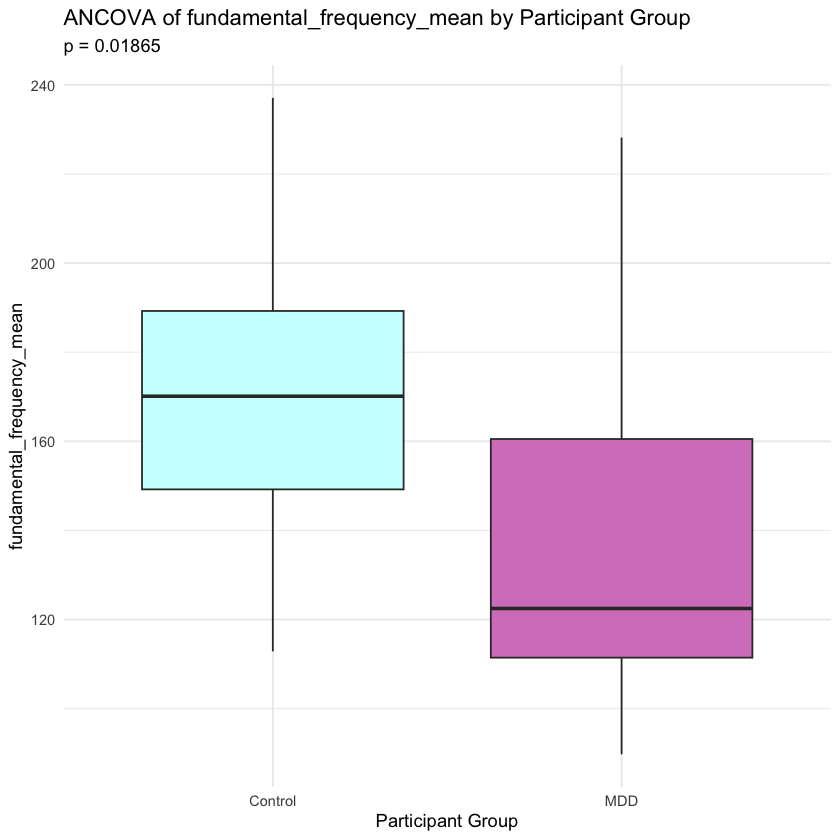


$fundamental_frequency_variance_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


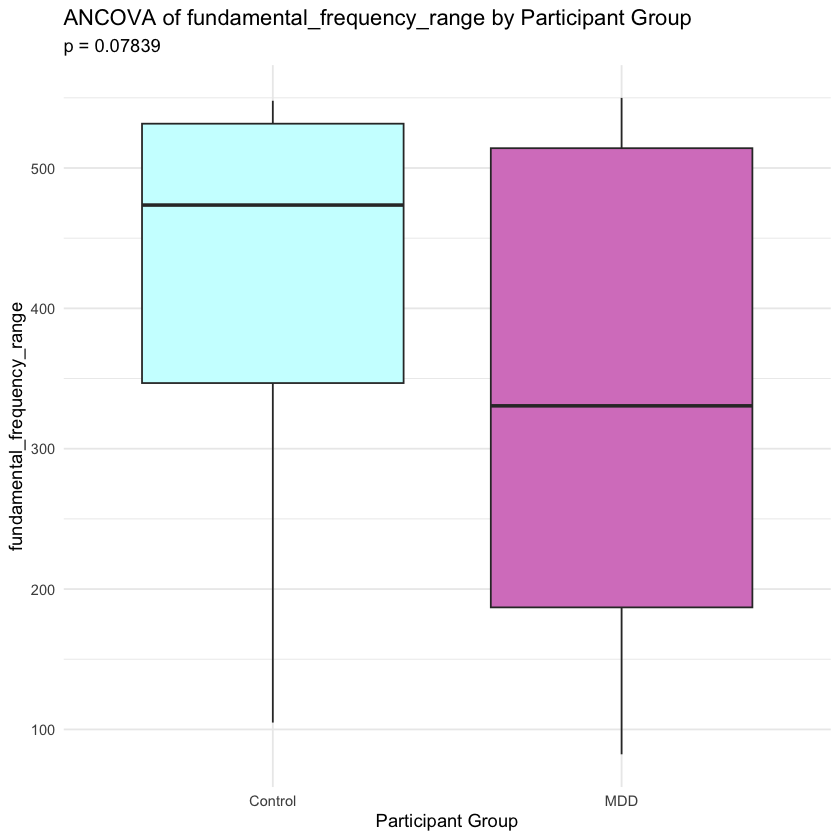


$intensity_mean_db_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


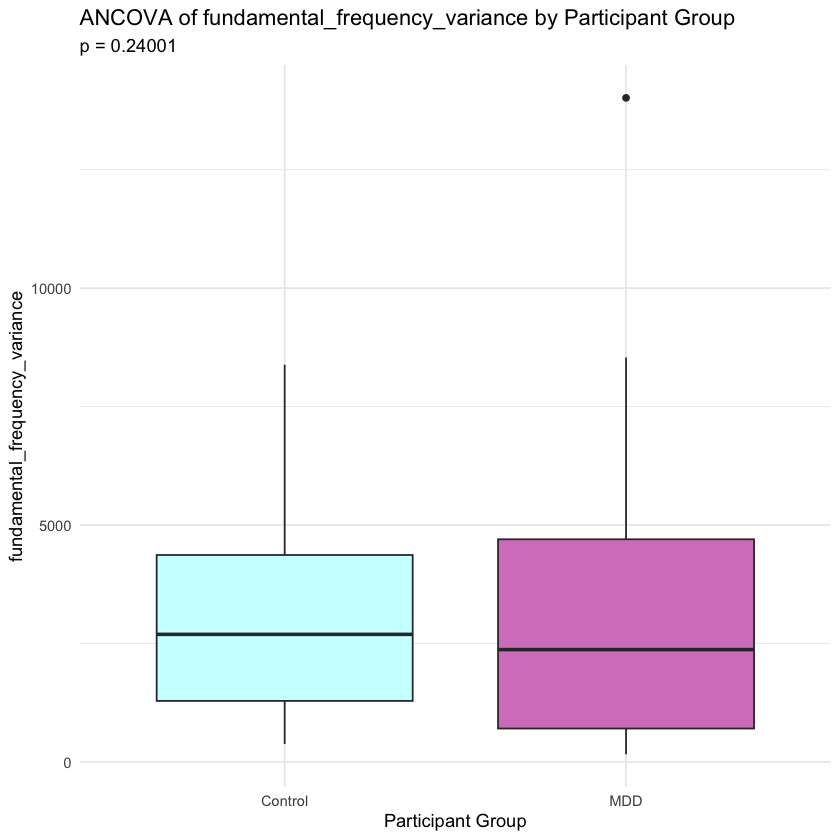


$intensity_range_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


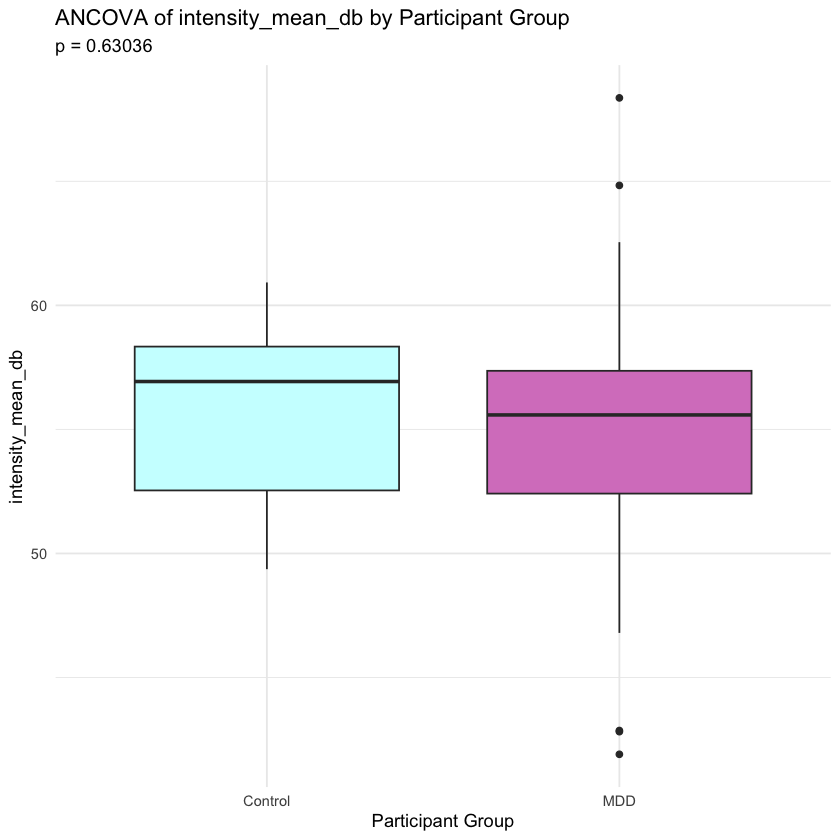


$long_pause_count_normalized_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


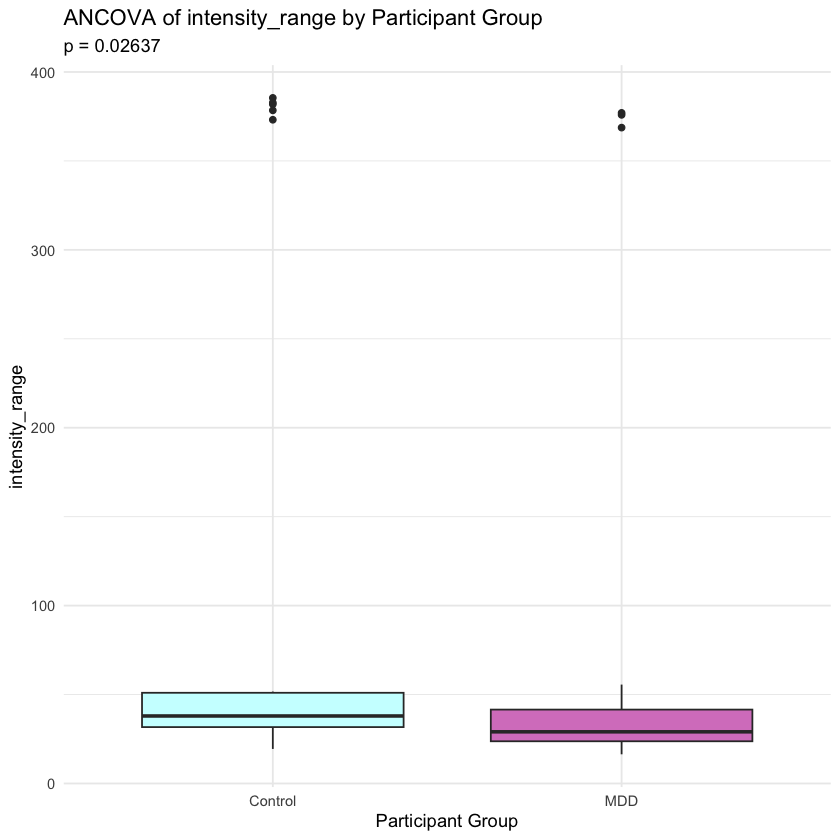


$long_pause_duration_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


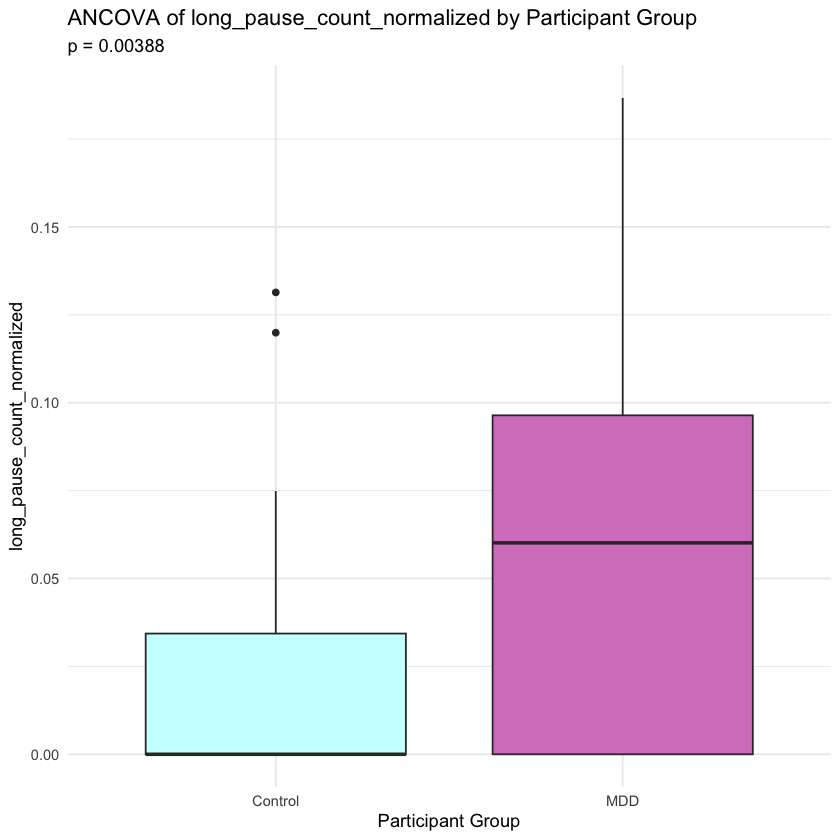


$medium_pause_count_normalized_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


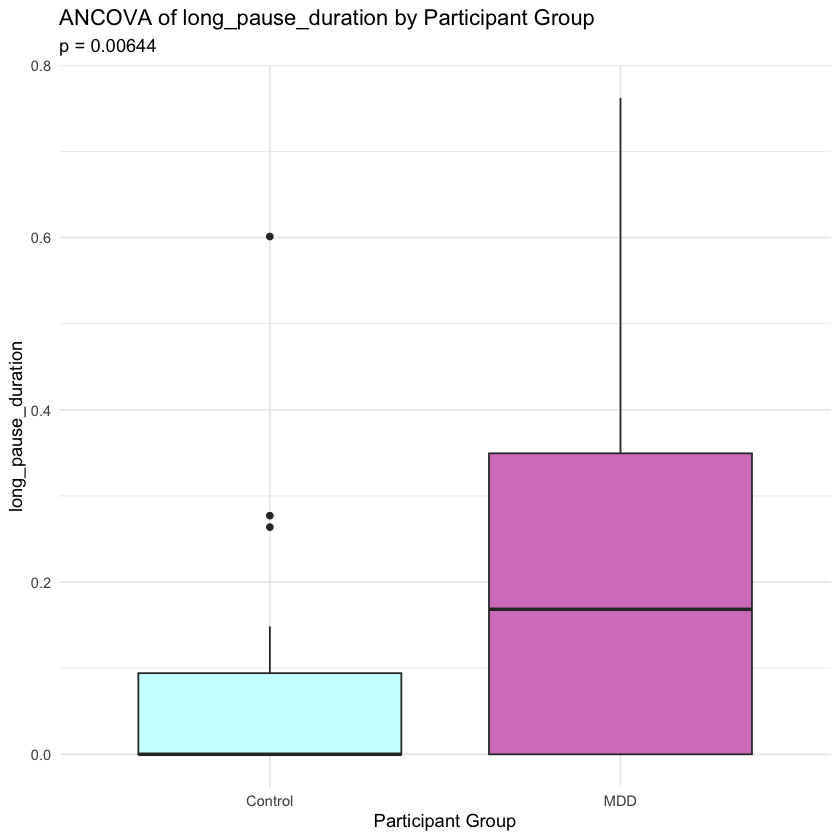


$medium_pause_duration_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


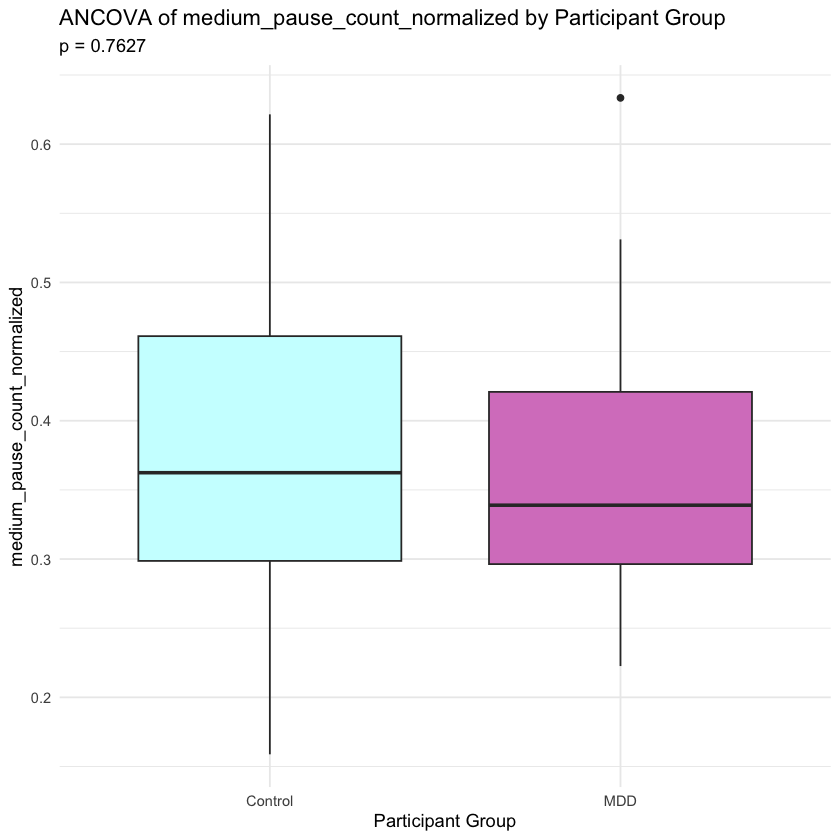


$speech_rate_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


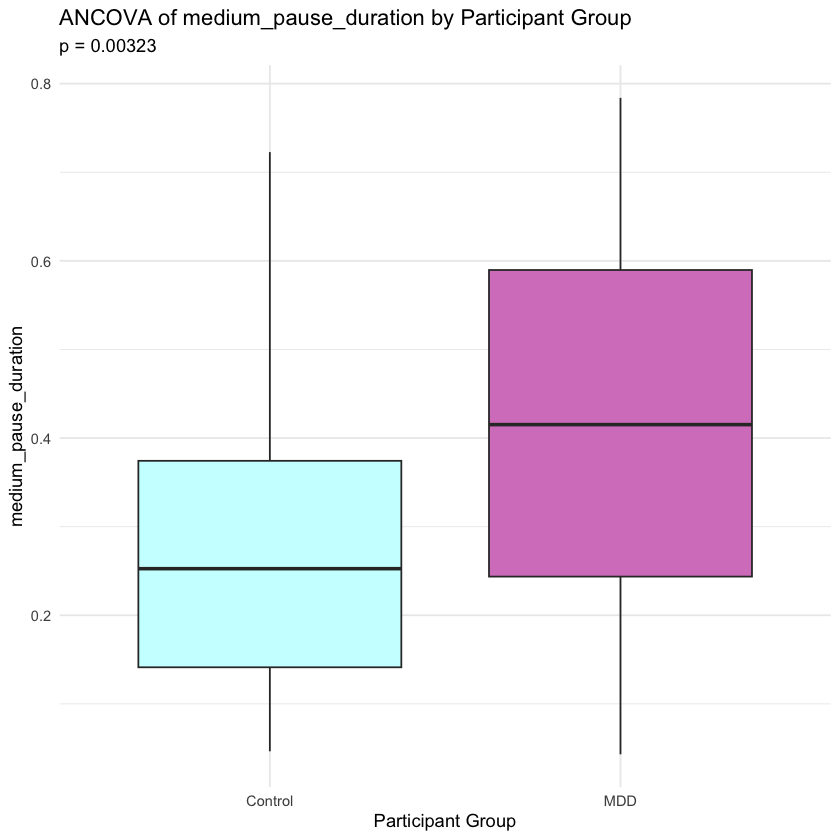


$sentiment_dominance_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


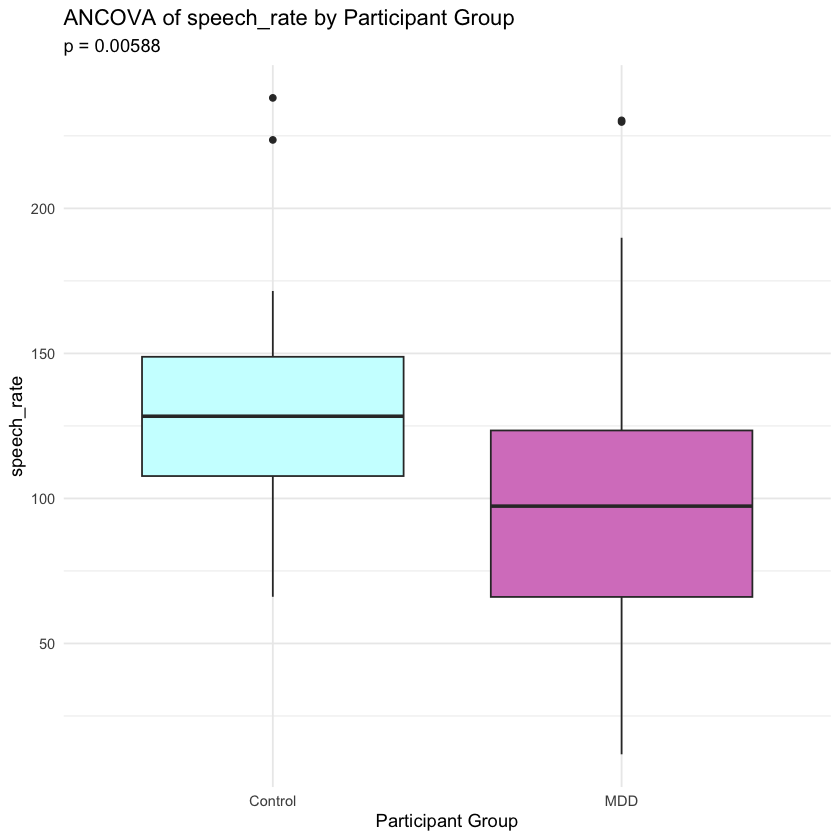


$sentiment_valence_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


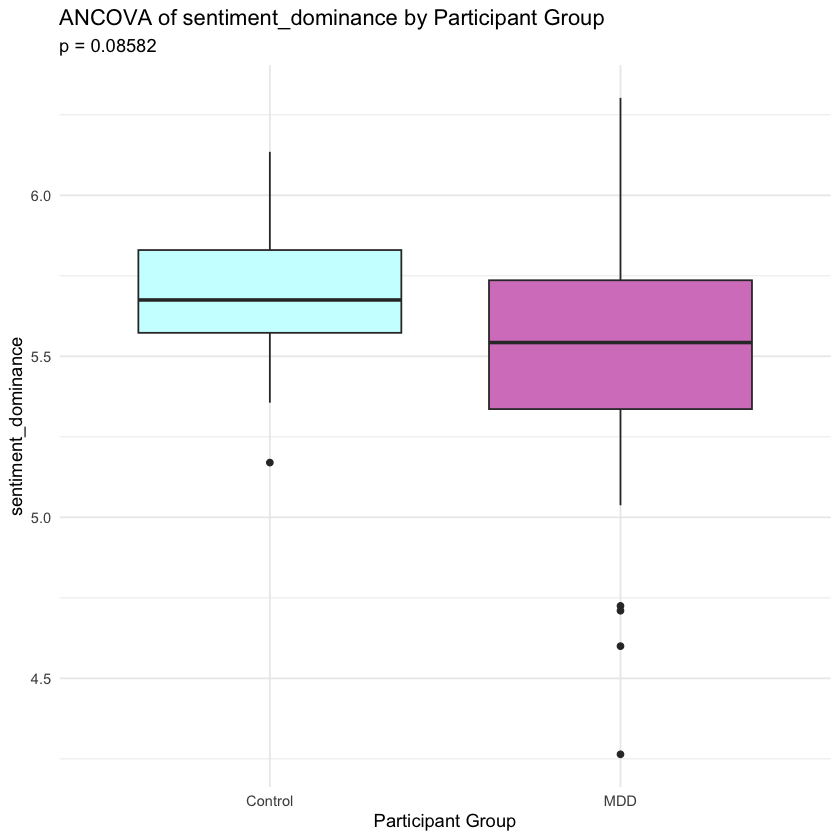


$sentiment_arousal_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


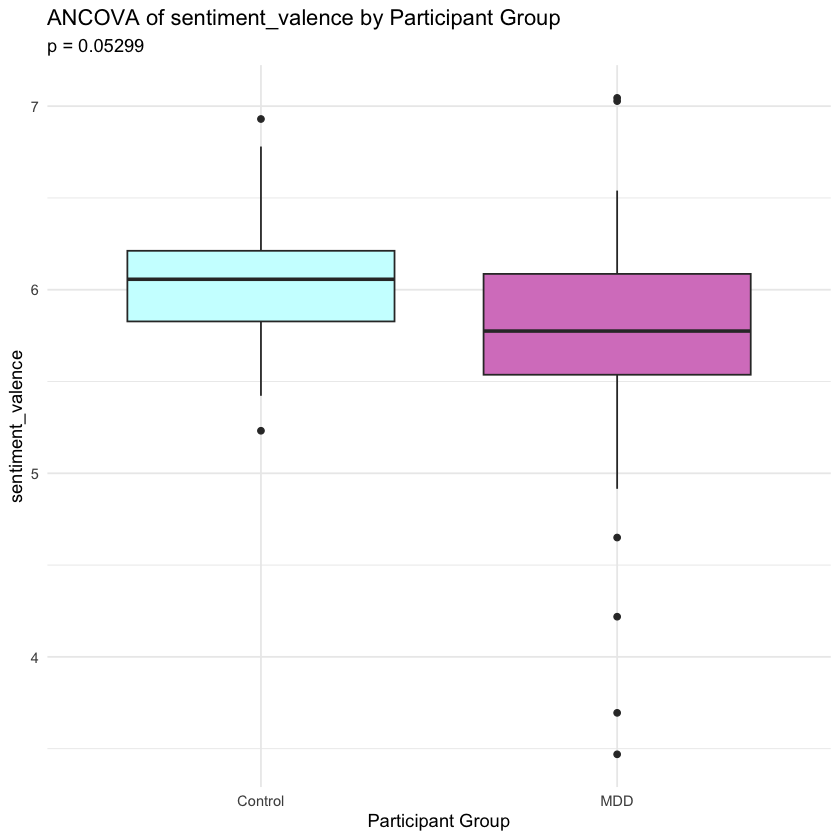

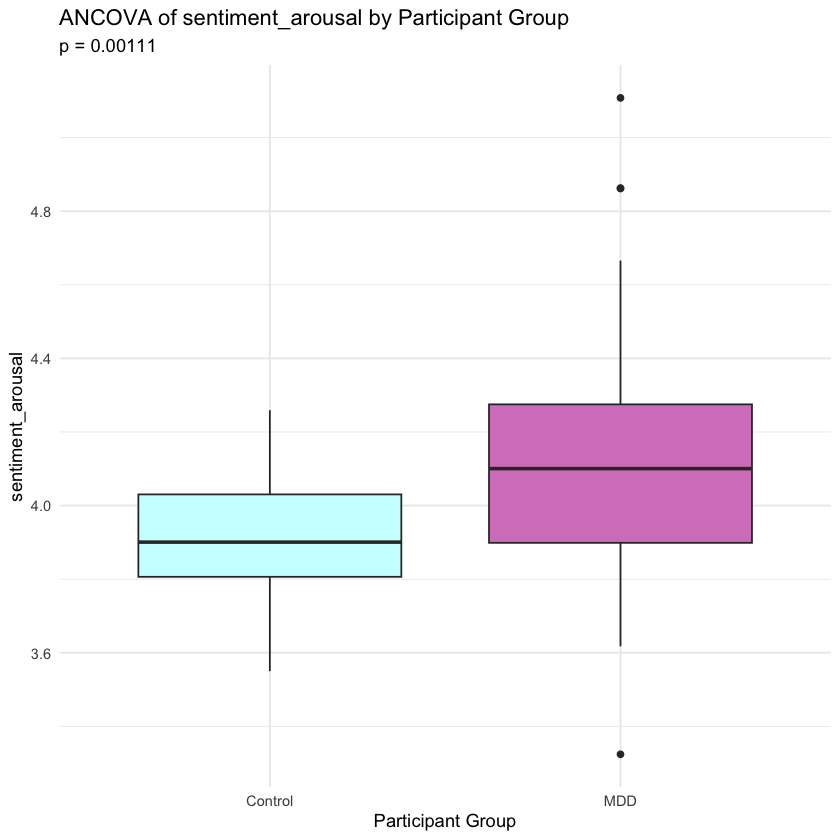

In [62]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("sex", "age_learned_english", "age_screening")
plots <- list()
results_ancova <- list()

WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]

    # Fit the linear model on the filtered data
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Seperate ANCOVAs by sex: Male

$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                     Sum Sq Df F value   Pr(>F)    
(Intercept)         25194.4  1 65.4302 1.92e-08 ***
participant_group    1726.3  1  4.4831  0.04435 *  
age_learned_english    45.8  1  0.1190  0.73305    
age_screening        1177.9  1  3.0590  0.09256 .  
Residuals            9626.5 25                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_range
Anova Table (Type III tests)

Response: fundamental_frequency_range
                    Sum Sq Df F value Pr(>F)
(Intercept)          80978  1  2.5212 0.1249
participant_group     7568  1  0.2356 0.6316
age_learned_english  19684  1  0.6128 0.4411
age_screening        88976  1  2.7702 0.1085
Residuals           802968 25               

$fundamental_frequency_variance
Anova Table (Type III tests)

Response: fundamental_frequency_variance
                      Sum Sq Df F value  Pr(>F)  
(Int

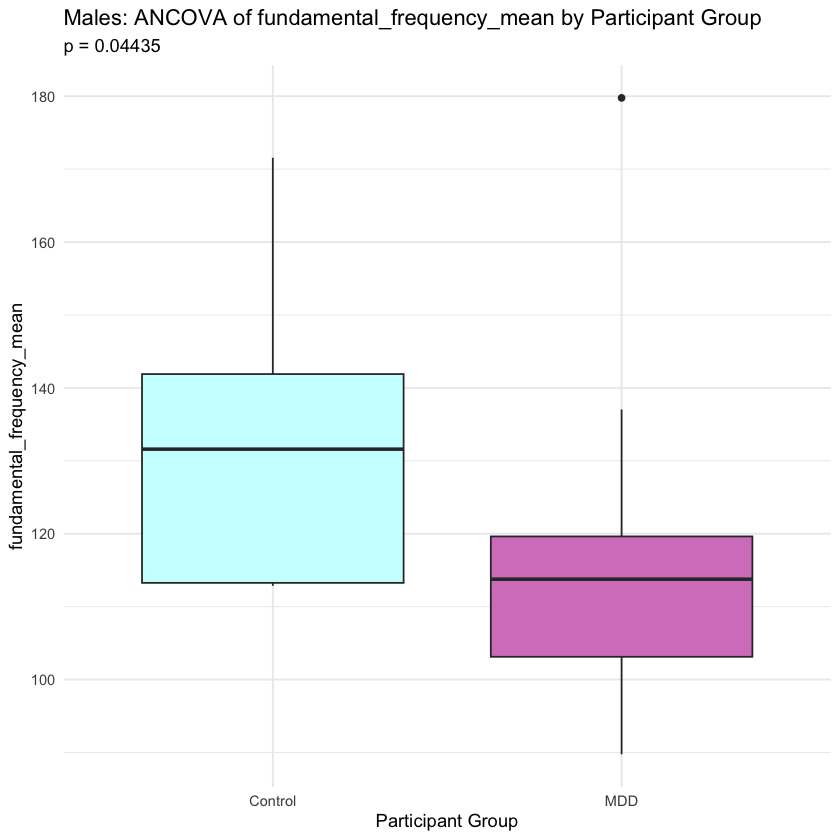


$fundamental_frequency_variance_ANCOVA_plot


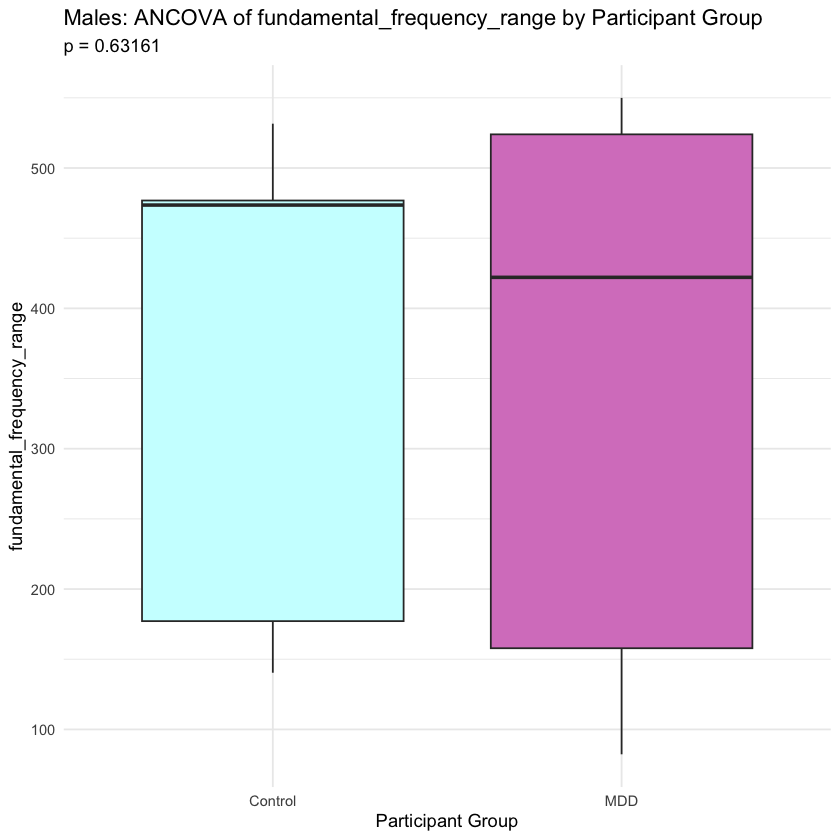


$intensity_mean_db_ANCOVA_plot


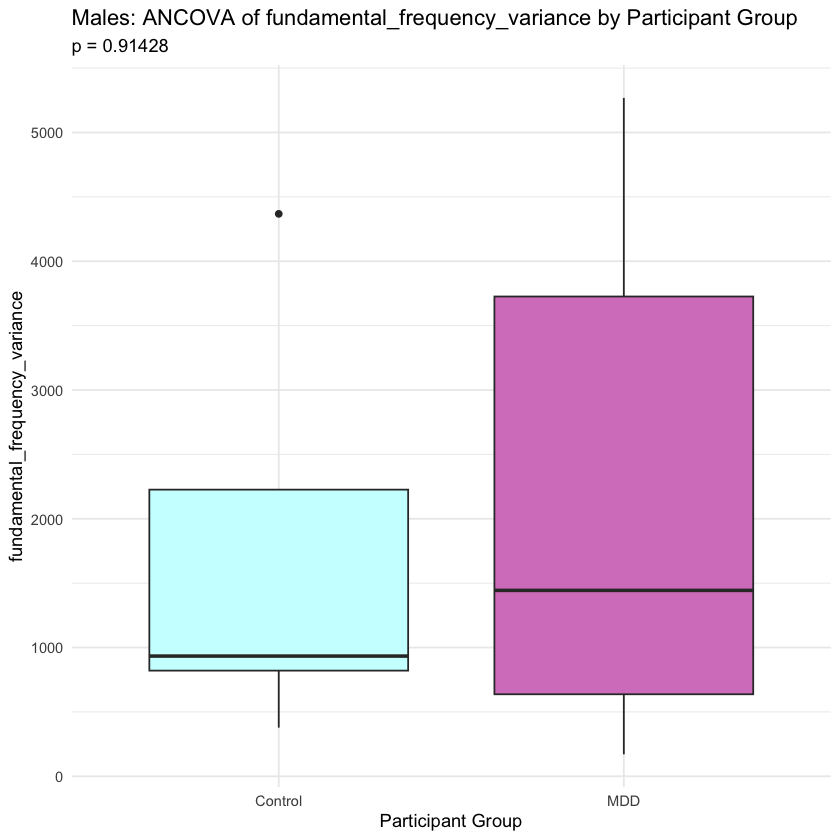


$intensity_range_ANCOVA_plot


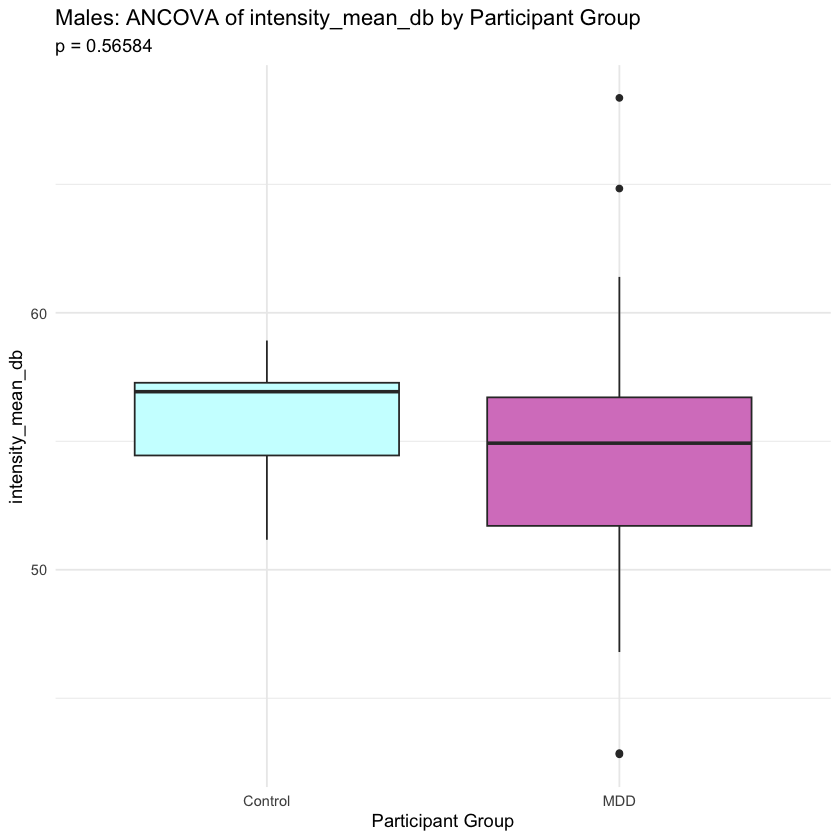


$long_pause_count_normalized_ANCOVA_plot


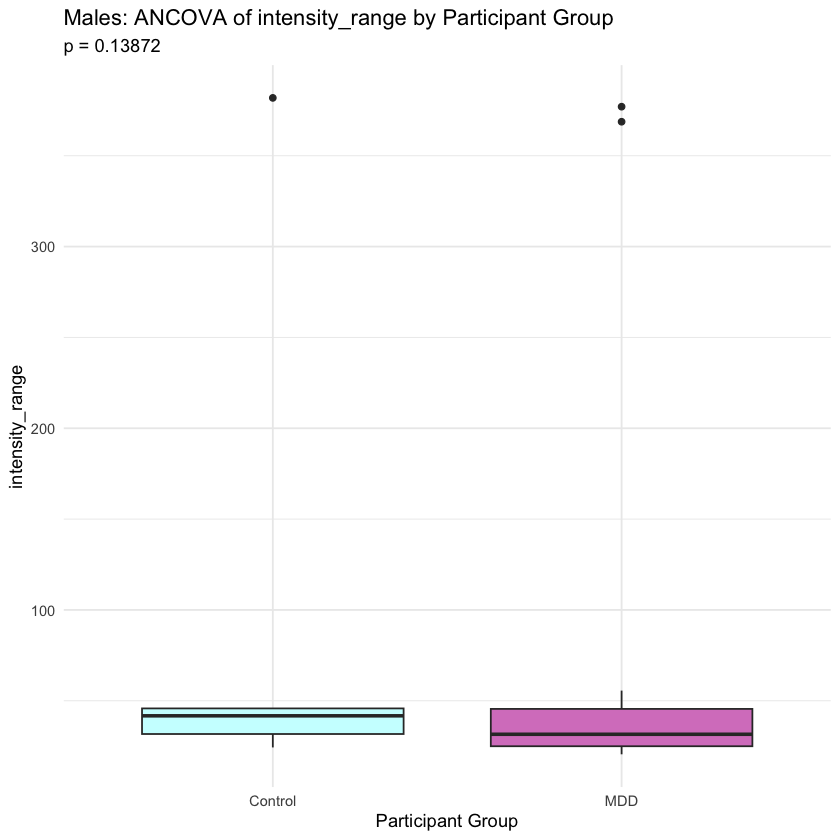


$long_pause_duration_ANCOVA_plot


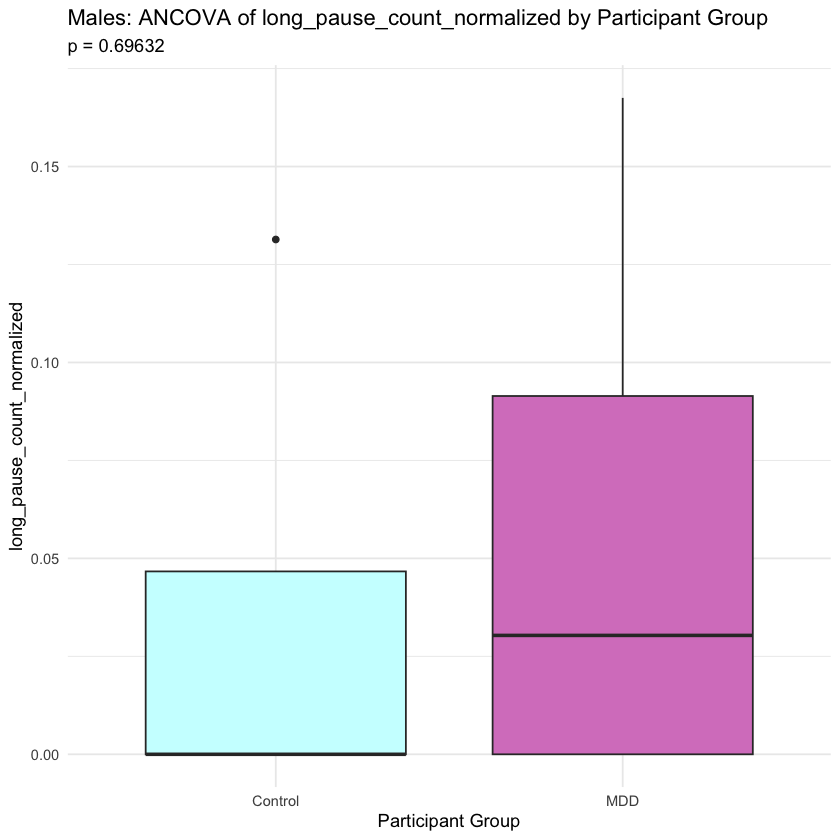


$medium_pause_count_normalized_ANCOVA_plot


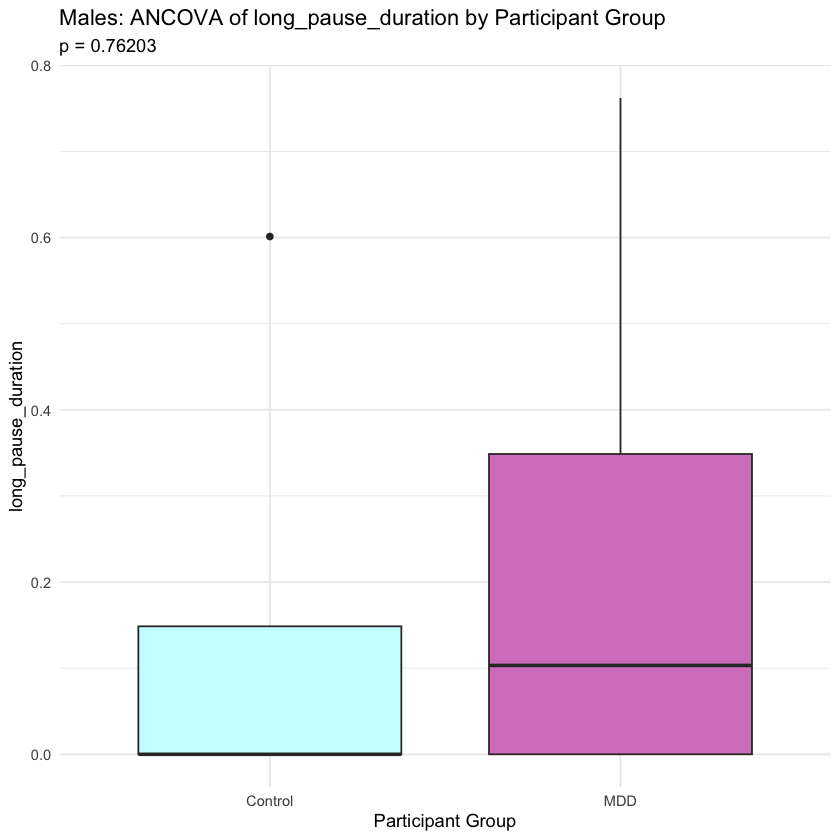


$medium_pause_duration_ANCOVA_plot


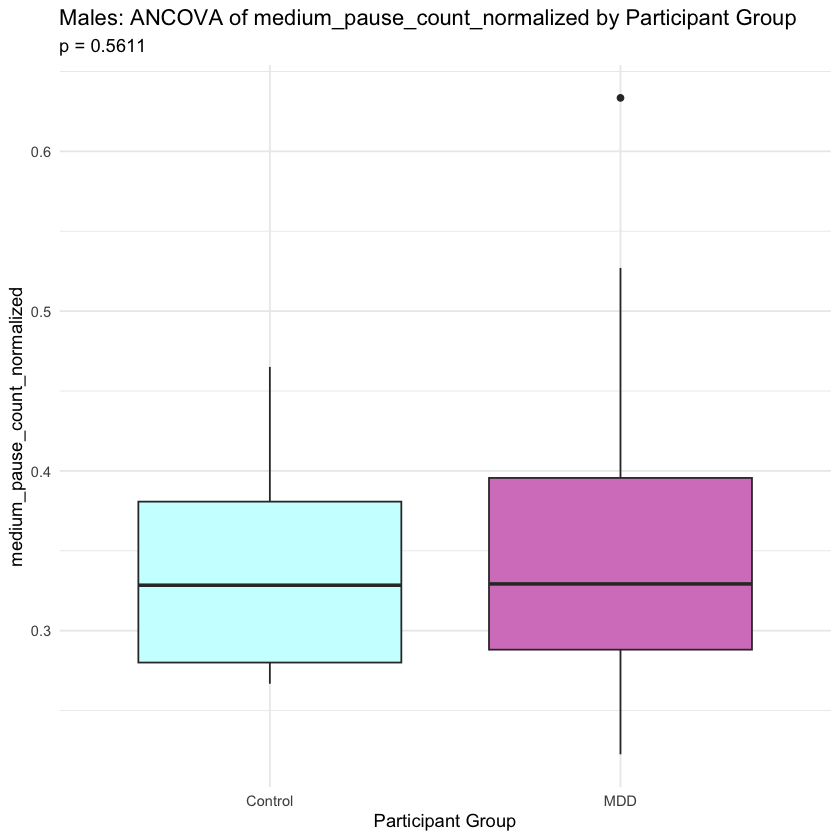


$speech_rate_ANCOVA_plot


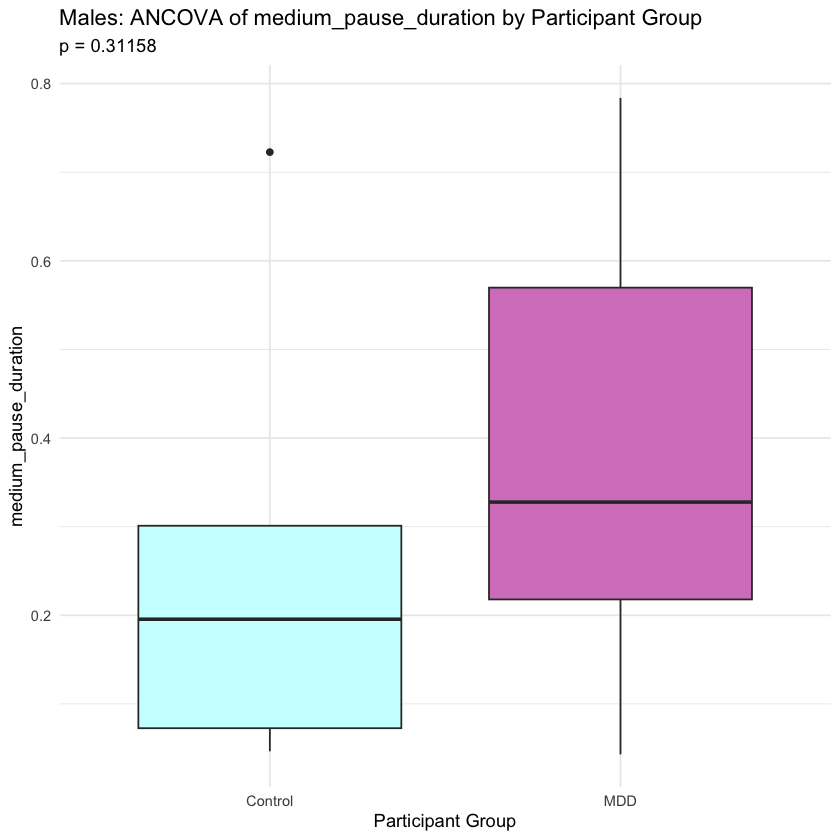


$sentiment_dominance_ANCOVA_plot


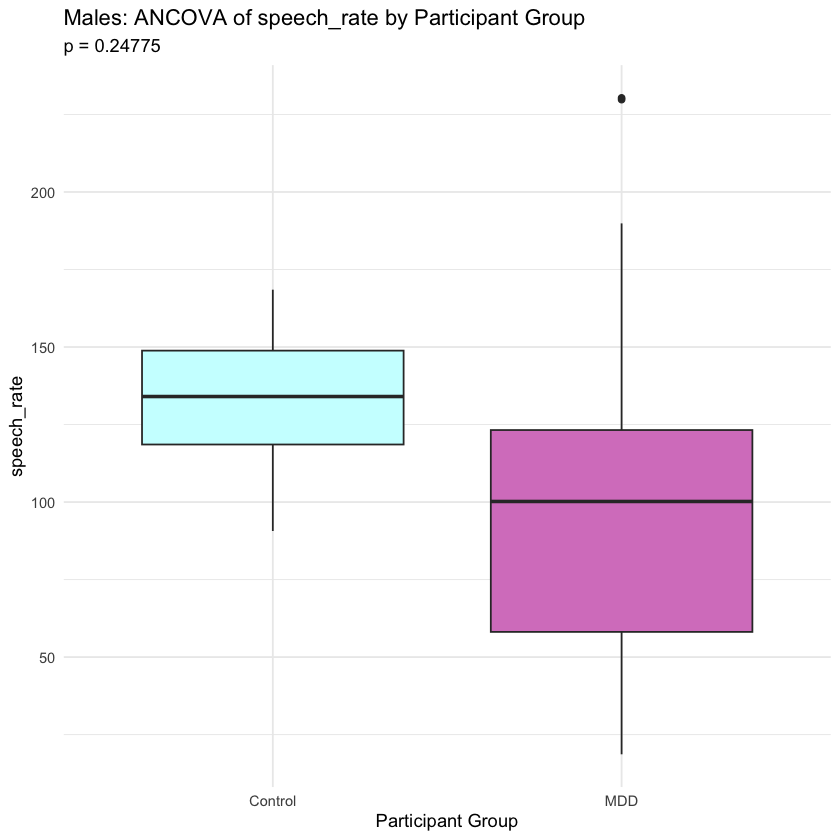


$sentiment_valence_ANCOVA_plot


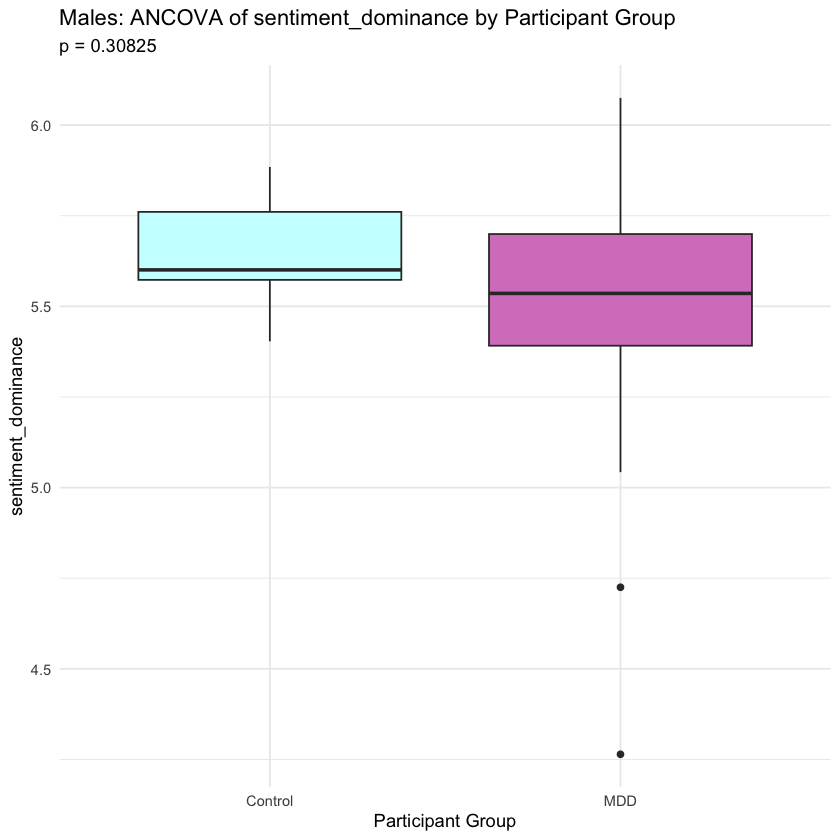


$sentiment_arousal_ANCOVA_plot


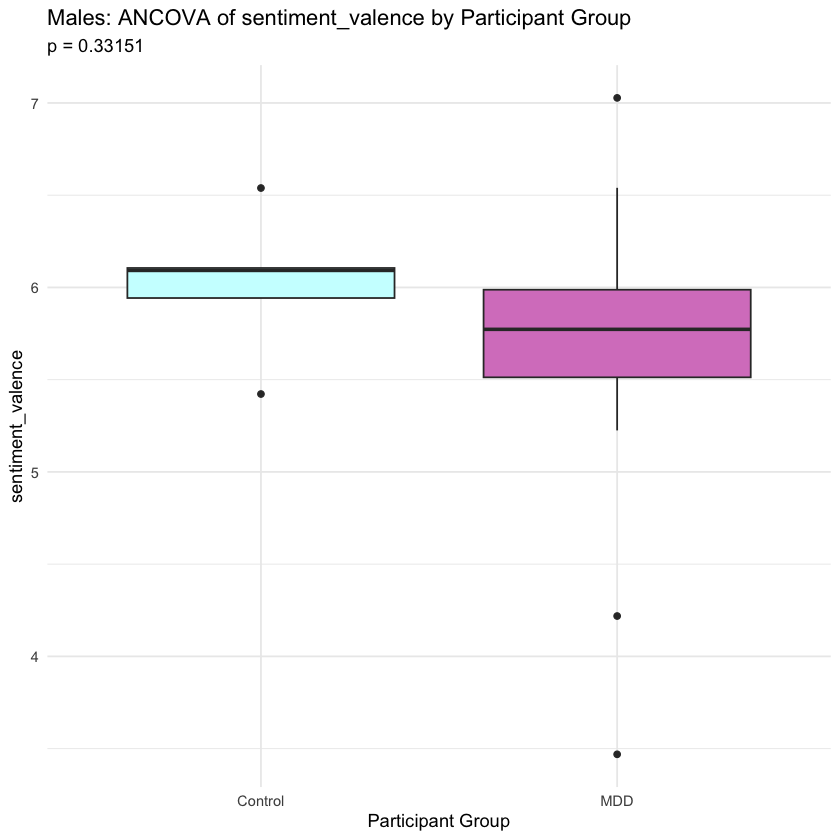

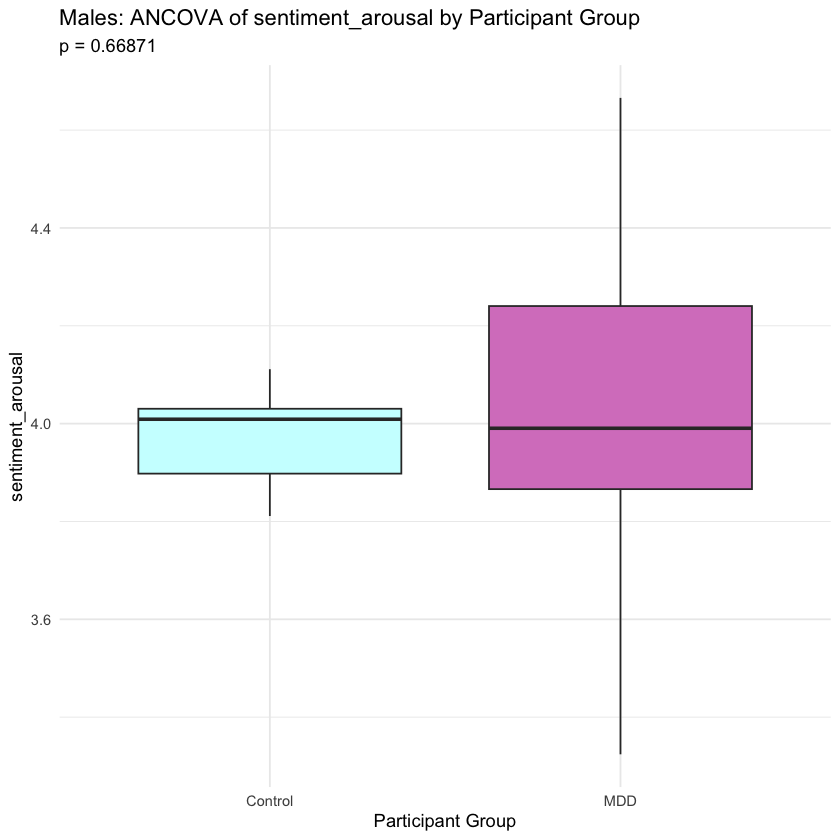

In [63]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("age_learned_english", "age_screening")
plots_male <- list()
results_ancova_male <- list()
WL_male_jou_bl <-WL_jou_bl_feeling[WL_jou_bl_feeling$sex == "M",]


for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_male_jou_bl[!is.na(WL_male_jou_bl$participant_group), ]

    # Fit the linear model on the filtered data
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("Males: ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Seperate ANCOVAS by sex: Female

$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                    Sum Sq Df  F value    Pr(>F)    
(Intercept)         156188  1 168.7951 2.337e-15 ***
participant_group     3591  1   3.8813   0.05635 .  
age_learned_english     81  1   0.0873   0.76935    
age_screening         3679  1   3.9764   0.05355 .  
Residuals            34237 37                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_range
Anova Table (Type III tests)

Response: fundamental_frequency_range
                    Sum Sq Df F value    Pr(>F)    
(Intercept)         870142  1 46.2845 5.191e-08 ***
participant_group   100053  1  5.3220   0.02676 *  
age_learned_english  10334  1  0.5497   0.46313    
age_screening        15810  1  0.8410   0.36505    
Residuals           695595 37                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_variance
Anova Tabl

Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."



$fundamental_frequency_range_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


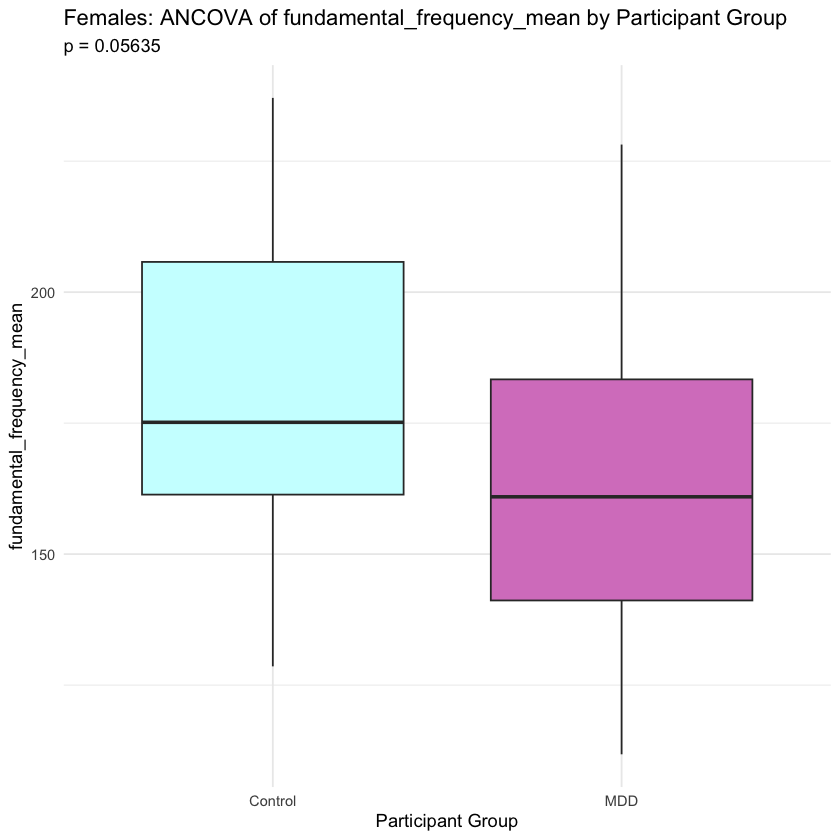


$fundamental_frequency_variance_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


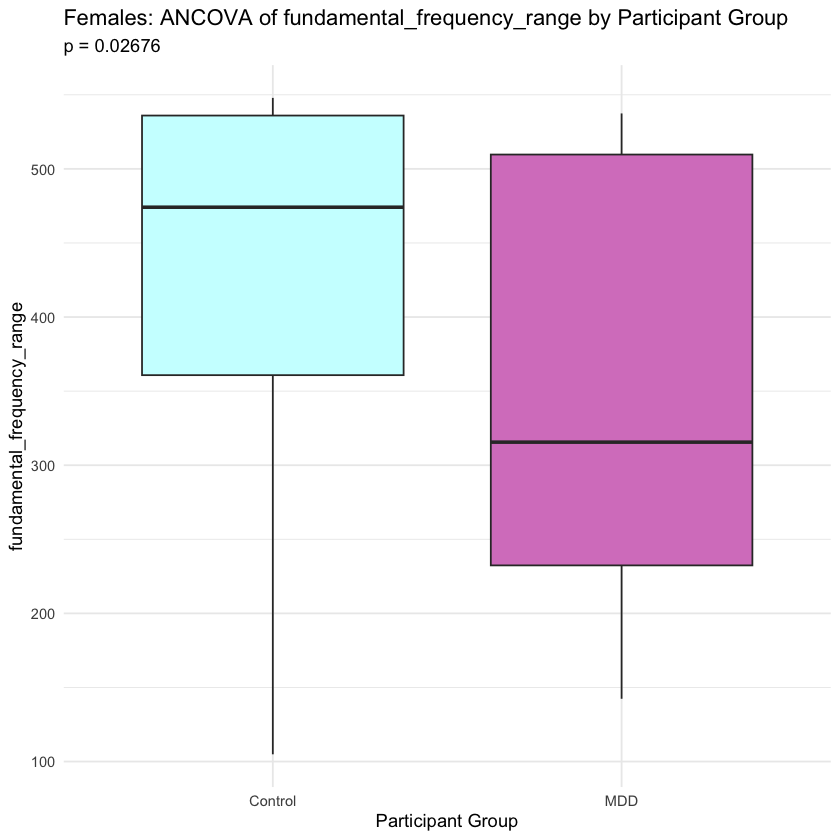


$intensity_mean_db_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


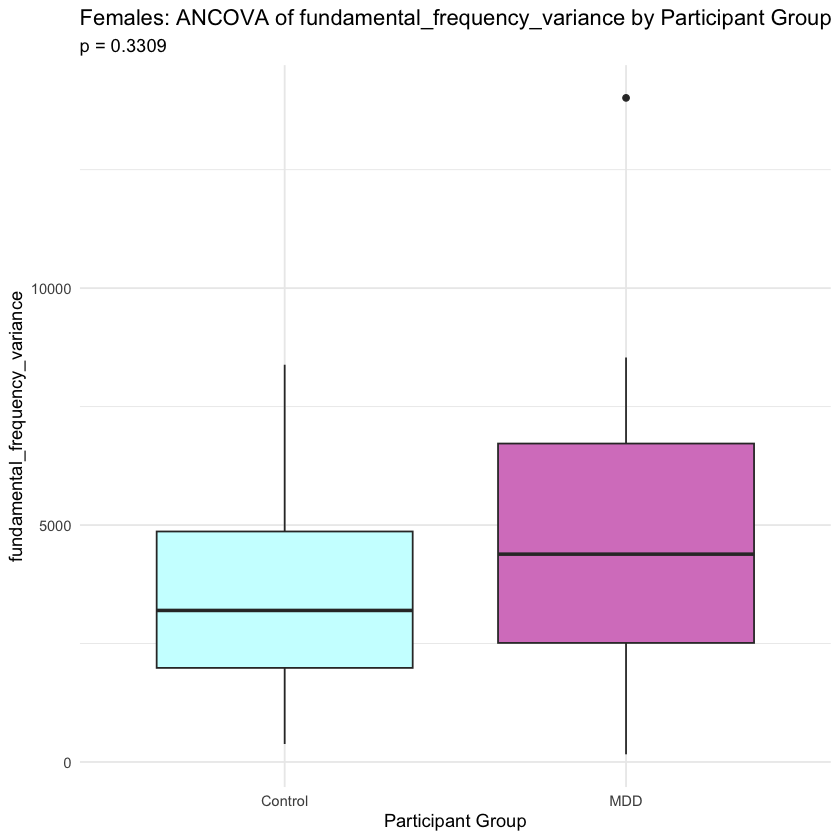


$intensity_range_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


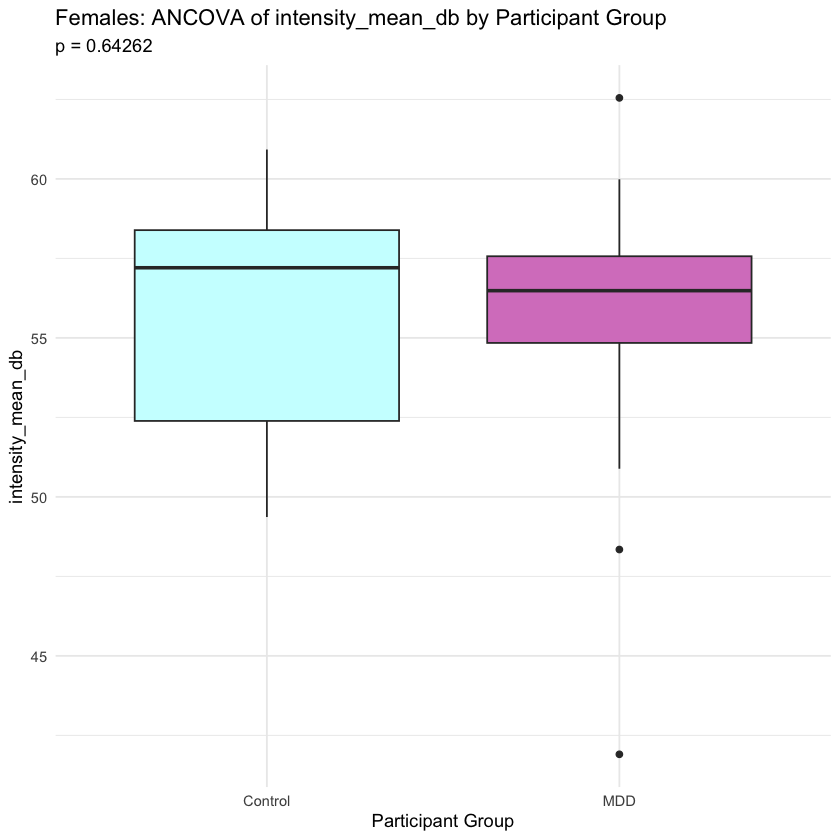


$long_pause_count_normalized_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


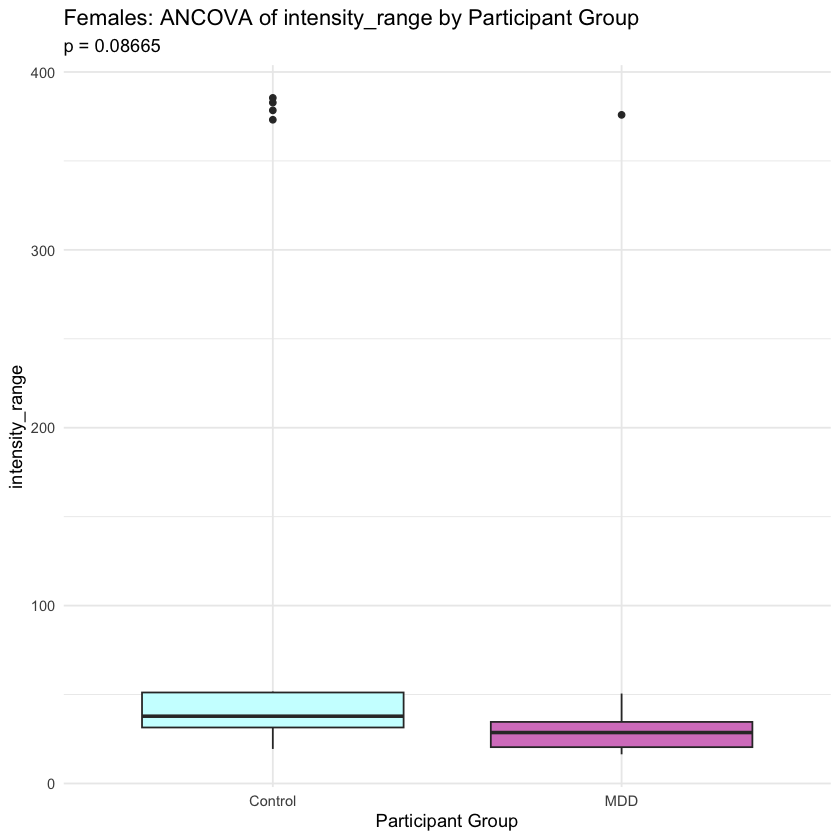


$long_pause_duration_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


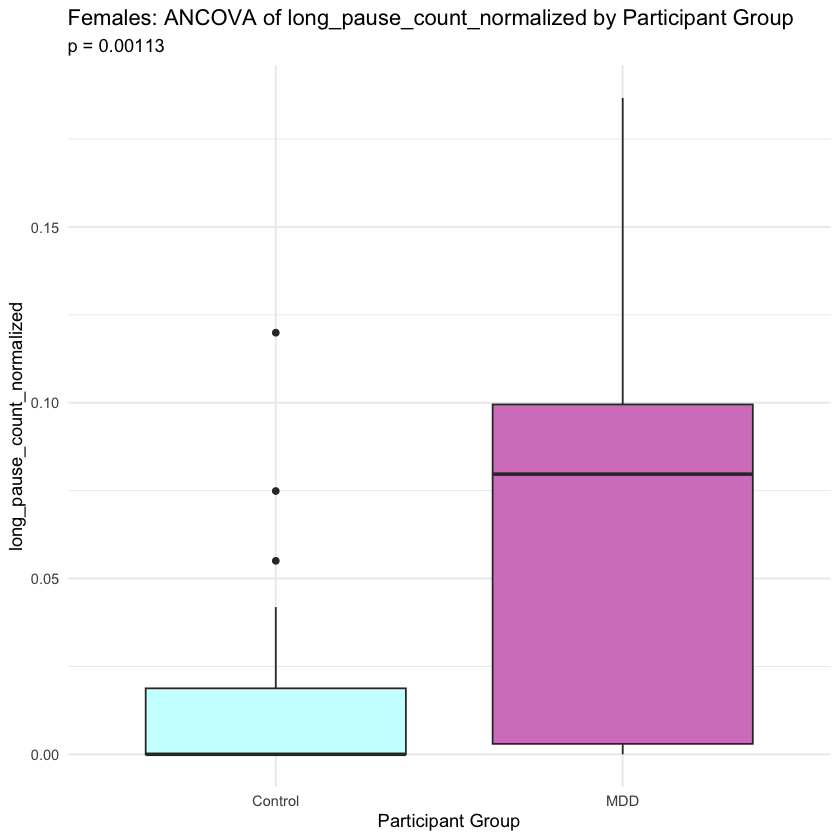


$medium_pause_count_normalized_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


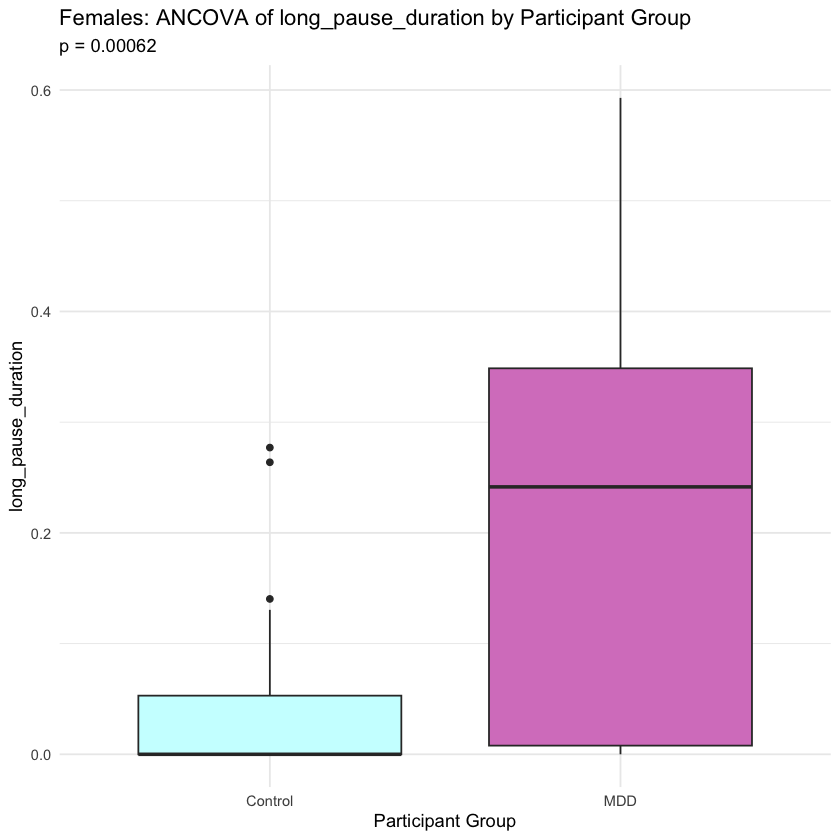


$medium_pause_duration_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


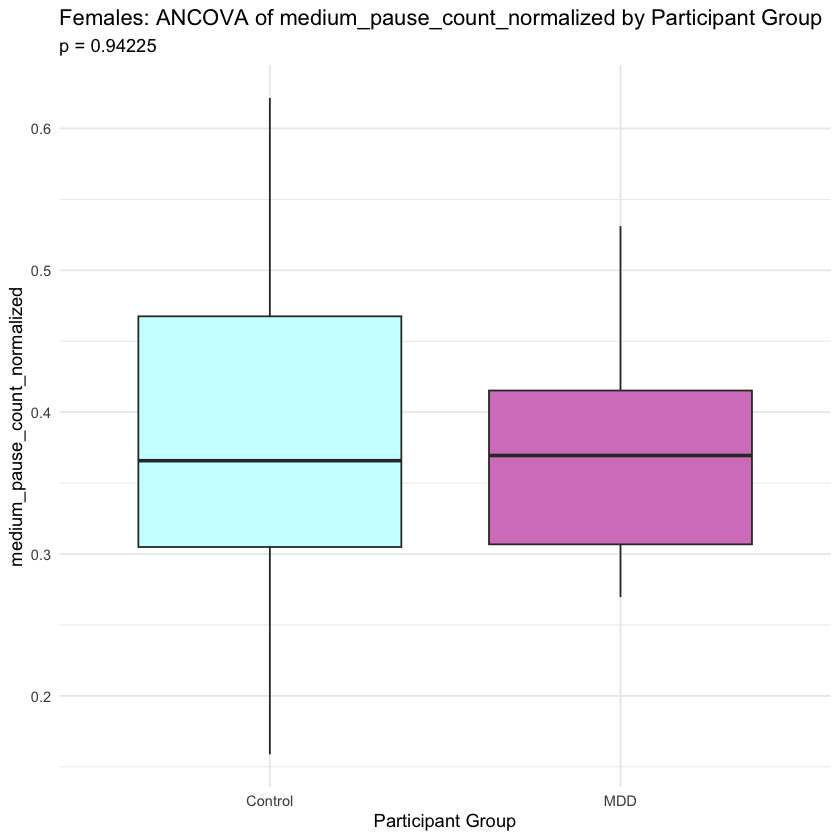


$speech_rate_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


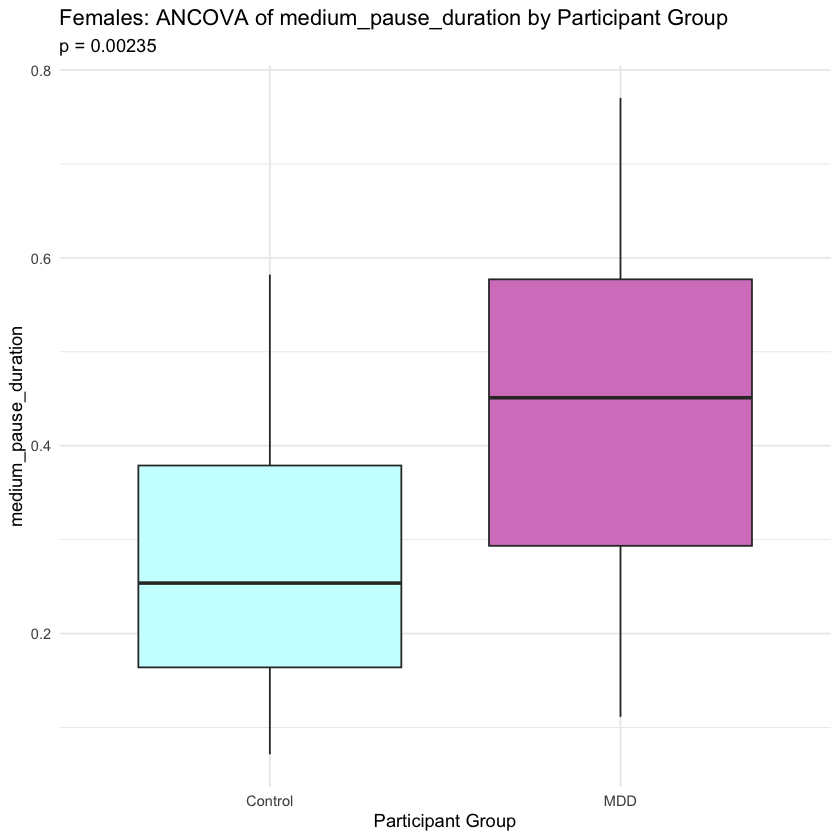


$sentiment_dominance_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


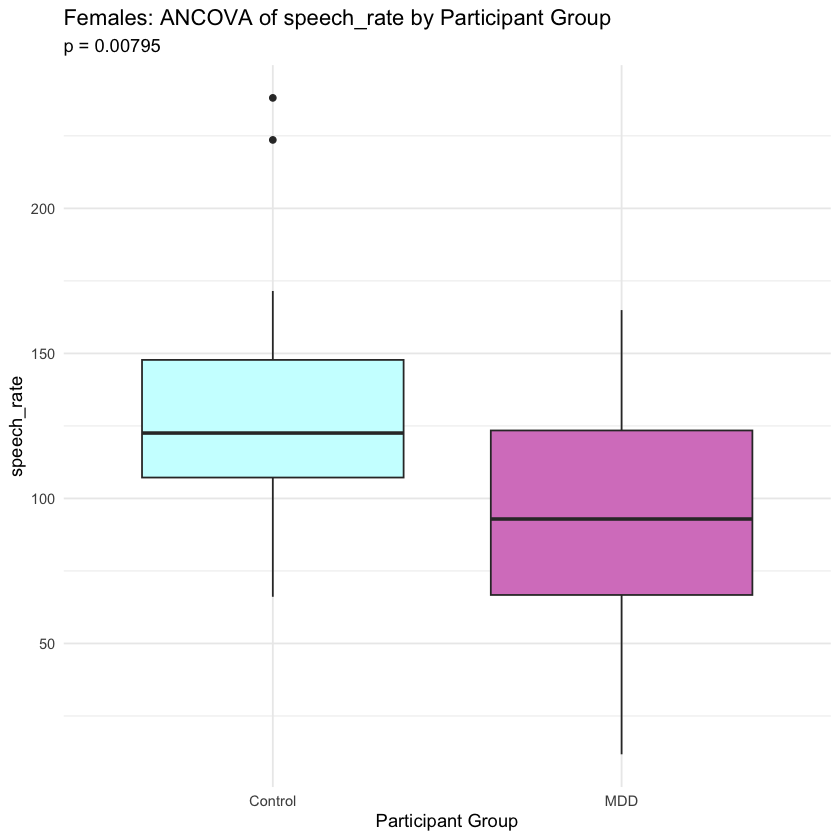


$sentiment_valence_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


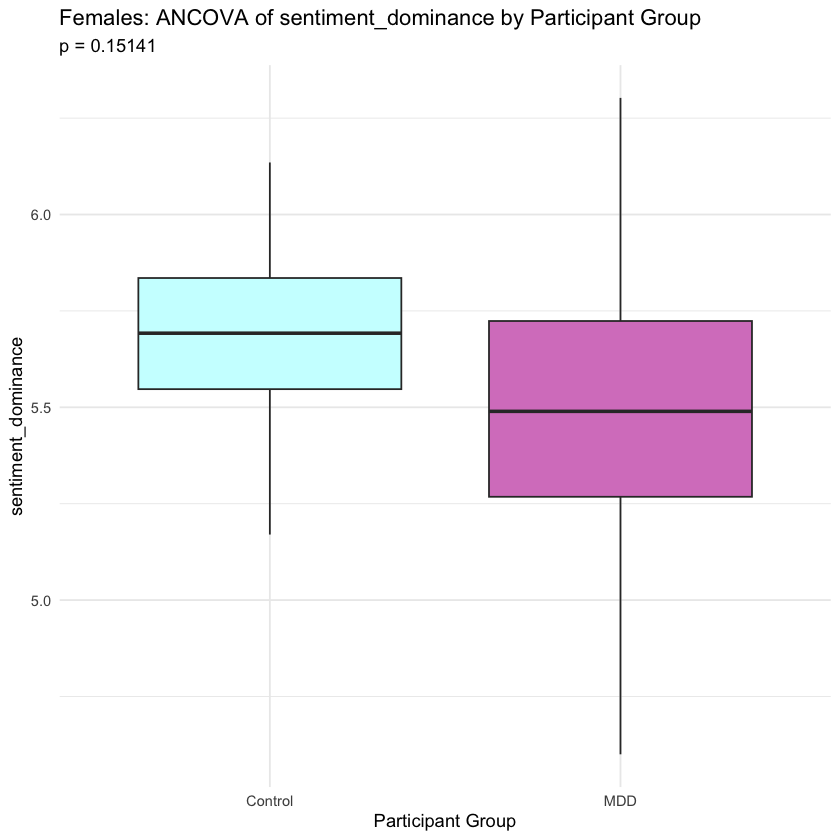


$sentiment_arousal_ANCOVA_plot


Warning message:
"Removed 1 rows containing non-finite values (`stat_boxplot()`)."


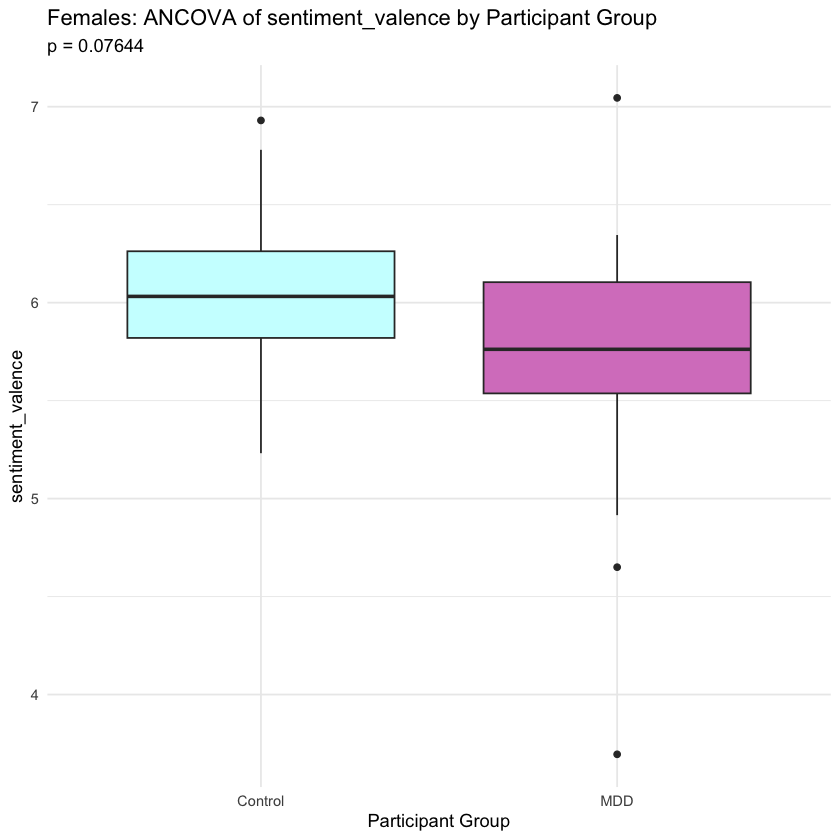

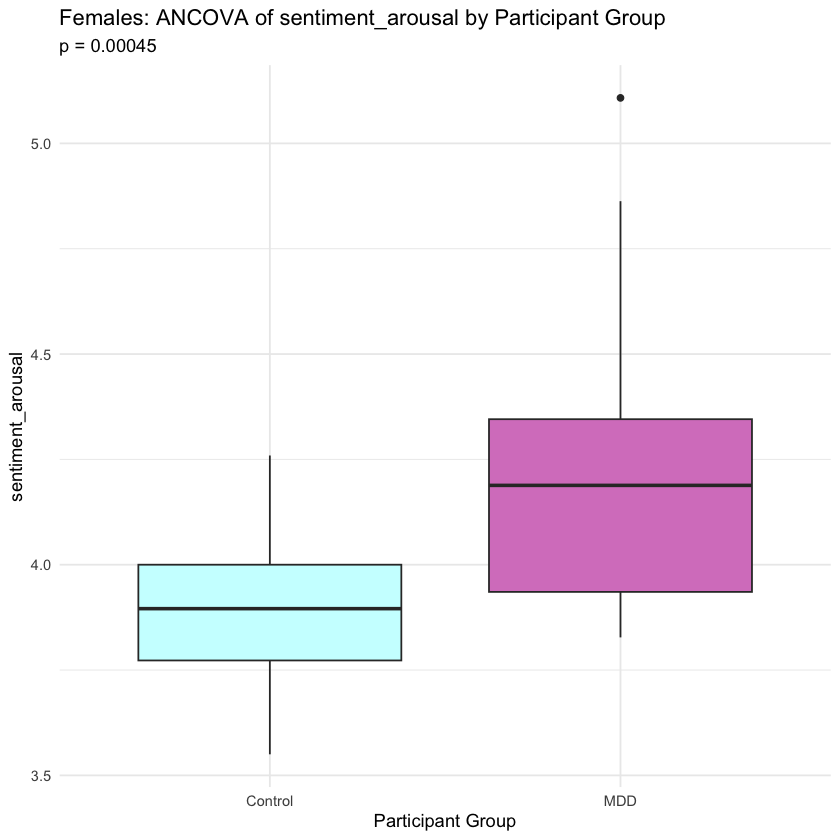

In [64]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("age_learned_english", "age_screening")
plots_male <- list()
results_ancova_male <- list()
WL_fem_jou_bl <-WL_jou_bl_feeling[WL_jou_bl_feeling$sex == "F",]


for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_fem_jou_bl[!is.na(WL_fem_jou_bl$participant_group), ]

    # Fit the linear model on the filtered data
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("Females: ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Sample Size

In [69]:
# Count unique IDs for each combination of sex and participant group
unique_counts <- WL_jou_bl_feeling %>%
  group_by(participant_group, sex) %>%
  summarise(unique_ids = n_distinct(participant_external_id))

# Print the result
print(unique_counts)

library(dplyr)

# Filter rows where both sex and participant_group are NA
na_participants <- WL_jou_bl_feeling %>%
  filter(is.na(sex) | is.na(participant_group)) %>%
  distinct(participant_external_id)

# Print the result
print(na_participants)


`summarise()` has grouped output by 'participant_group'. You can override using
the `.groups` argument.


# A tibble: 6 x 3
# Groups:   participant_group [3]
  participant_group sex   unique_ids
  <fct>             <fct>      <int>
1 Control           F             21
2 Control           M              5
3 MDD               F             22
4 MDD               M             27
5 MDD               NA             1
6 NA                NA             1
# A tibble: 2 x 1
  participant_external_id
  <chr>                  
1 TMS028                 
2 CTB001                 
